In [1]:
import os
import glob
import copy
import time

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from collections import namedtuple
import SimpleITK as sitk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
df_annotations = pd.read_csv('/kaggle/input/luna16/annotations.csv')
df_annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [3]:
series=df_annotations[df_annotations['diameter_mm']==df_annotations['diameter_mm'].max()]

In [4]:
series

,seriesuid,coordX,coordY,coordZ,diameter_mm
765,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,67.827256,85.379925,-109.746724,32.27003


In [5]:
series_uid=df_annotations.iloc[765]['seriesuid']

In [6]:
filepaths = glob.glob(f'/kaggle/input/luna16/subset*/*/{series_uid}.mhd')
assert len(filepaths) != 0, f'CT scan with seriesuid {series_uid} not found!'
filepaths

['/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd']

In [7]:
mhd_file_path = filepaths[0]
mhd_file_path

'/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd'

In [8]:
mhd_file = sitk.ReadImage(mhd_file_path)

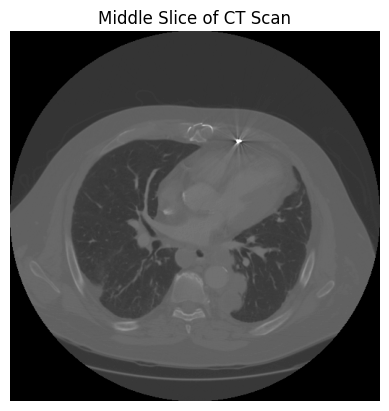

In [9]:
import matplotlib.pyplot as plt
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
middle_slice_index = ct_scan.shape[0] // 2
plt.imshow(ct_scan[middle_slice_index], cmap='gray')
plt.title('Middle Slice of CT Scan')
plt.axis('off')
plt.show()


In [10]:
ct_scan.clip(-1000, 1000, ct_scan)

array([[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-10

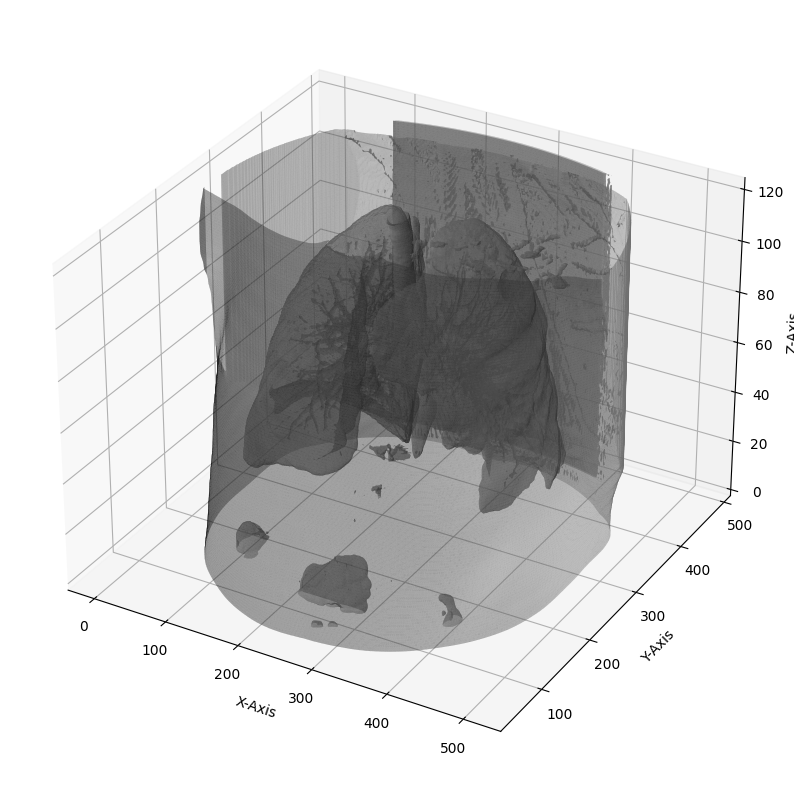

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure  
def plot_3d(image, threshold=-300):
    p = image.transpose(2,1,0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                           lw=0, alpha=0.5, color="gray")
    
    ax.set_xlabel("X-Axis")
    ax.set_ylabel("Y-Axis")
    ax.set_zlabel("Z-Axis")
    plt.show()
plot_3d(ct_scan)


In [12]:
origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

In [13]:
origin_xyz_np = np.array(origin_xyz)
voxel_size_xyz_np = np.array(voxel_size_xyz)

In [14]:
center_xyz=(67.827256,85.379925,-109.746724)

In [15]:
cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
cri = np.round(cri)
irc = (int(cri[2]), int(cri[1]), int(cri[0]))

In [16]:
irc

(91, 360, 341)

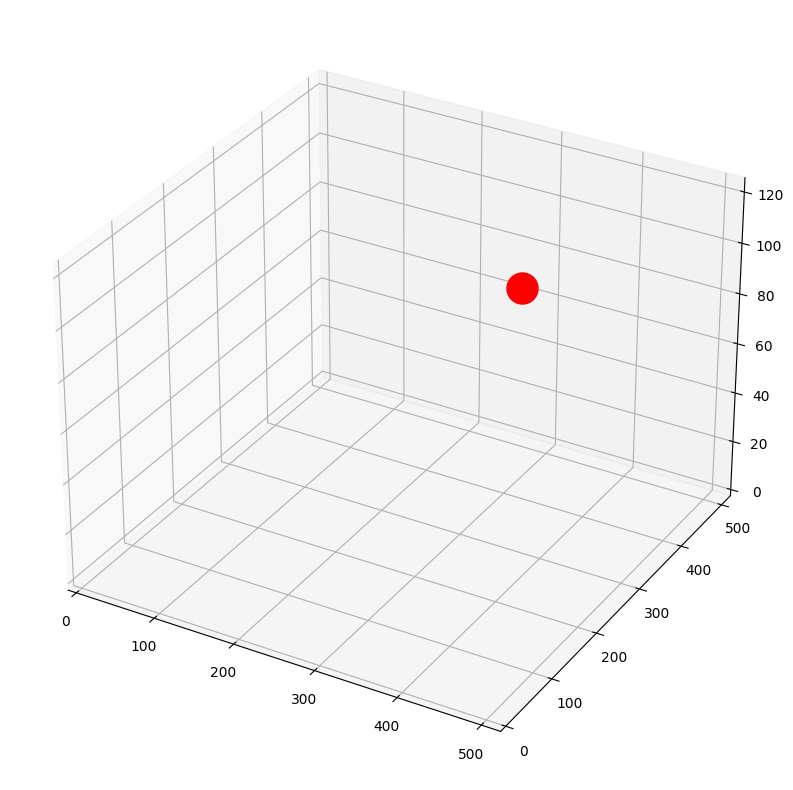

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(irc[2], irc[1], irc[0], c='r', s=500)
ax.set_xlim(0, ct_scan.shape[2])
ax.set_ylim(0, ct_scan.shape[1])
ax.set_zlim(0, ct_scan.shape[0])
plt.show()


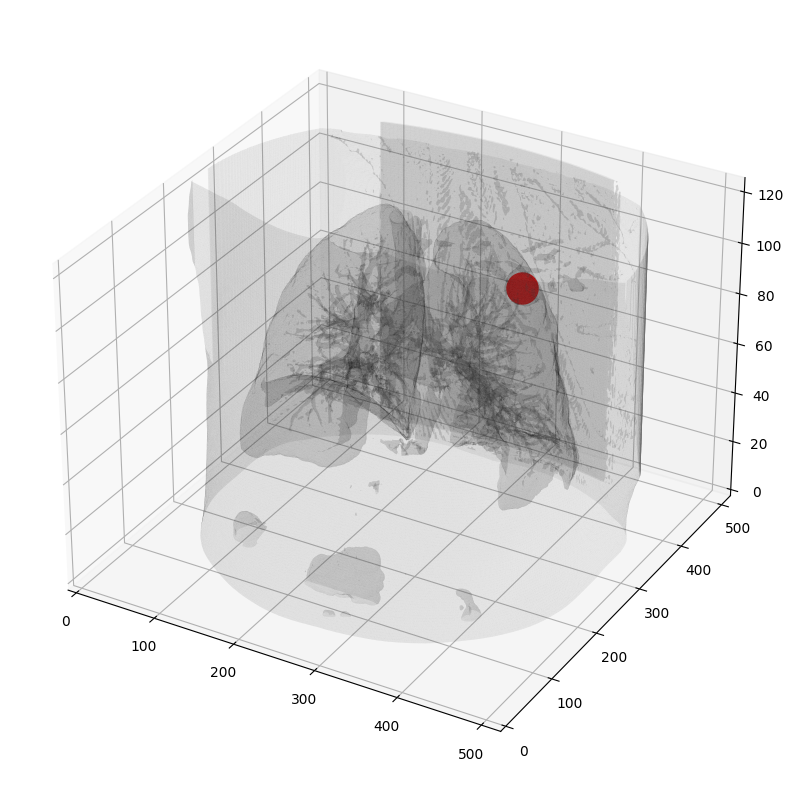

In [18]:
from skimage import measure
import matplotlib.pyplot as plt
def plot_3d_with_nodule(image, threshold=-300, nodule_coords=None):
    p = image.transpose(2,1,0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    if nodule_coords:
        ax.scatter(nodule_coords[2], nodule_coords[1], nodule_coords[0], c='r', s=500)
    mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], lw=0, alpha=0.1, color="grey")
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
plot_3d_with_nodule(ct_scan, nodule_coords=irc)


In [19]:
import matplotlib.pyplot as plt

def plot_slices(data, start_slice=0, end_slice=None, cols=4, figsize=(10, 8)):
    if end_slice is None:
        end_slice = data.shape[0]
    rows = (end_slice - start_slice + cols - 1) // cols
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    
    for i in range(rows * cols):
        current_slice = start_slice + i
        ax = plt.subplot(rows, cols, i + 1)
        if current_slice < end_slice:
            ax.imshow(data[current_slice], cmap='gray', vmin=-1000, vmax=400)
            ax.set_title(f"Slice {current_slice}")
        ax.axis("off")
    plt.show()


In [35]:
from skimage import morphology
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
def segment_and_mark_nodule(slice_image, threshold=-400):
    
    
    # Thresholding
    binary_mask = (slice_image > threshold).astype(np.uint8)
    opened_mask = morphology.opening(binary_mask, morphology.disk(2))
    labeled_mask = label(opened_mask)
    regions = regionprops(labeled_mask)
    if not regions:
        return slice_image
    largest_region = max(regions, key=lambda x: x.area)
    centroid = largest_region.centroid
    fig, ax = plt.subplots()
    ax.imshow(slice_image, cmap='gray')
    ax.axis('off')
    plt.show()
nodule_slice = ct_scan[irc[0]]



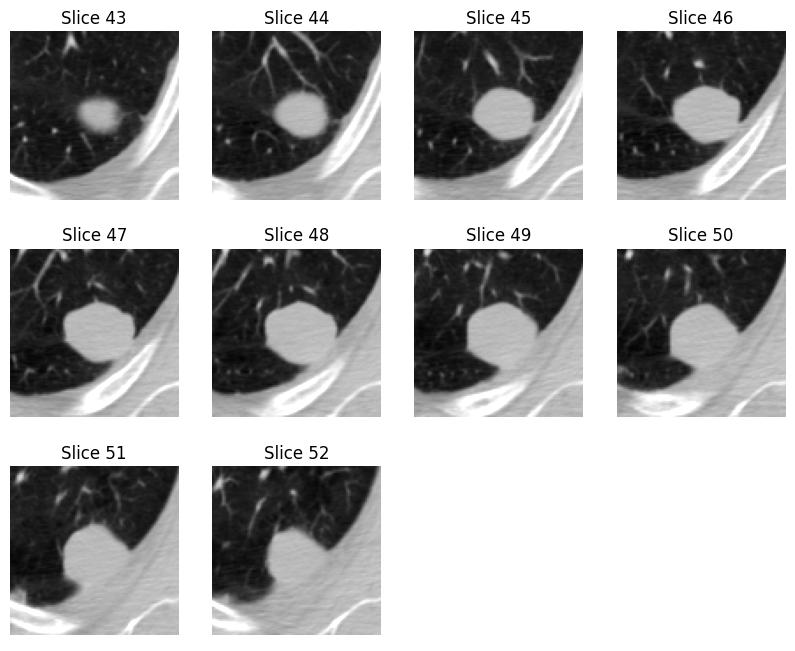

In [36]:
cube_size = 48  
roi = ct_scan[irc[0]-cube_size:irc[0]+cube_size,
              irc[1]-cube_size:irc[1]+cube_size,
              irc[2]-cube_size:irc[2]+cube_size]
middle_slice = cube_size
plot_slices(roi, middle_slice-5, middle_slice+5)


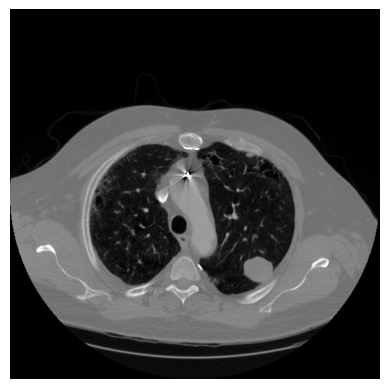

In [38]:
import matplotlib.pyplot as plt
def plot_slice_from_irc(ct_scan, irc):
    slice_image = ct_scan[irc[0]]
    plt.imshow(slice_image, cmap='gray')
    plt.axis('off')
    plt.show()
plot_slice_from_irc(ct_scan, irc)


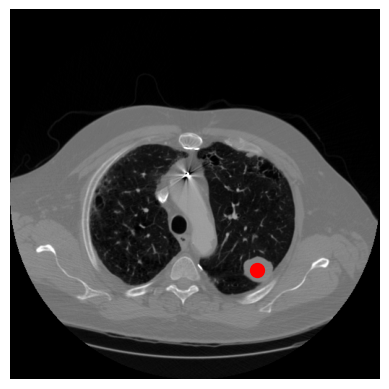

In [39]:
import matplotlib.pyplot as plt

def plot_slice_from_irc(ct_scan, irc):
    slice_image = ct_scan[irc[0]]
    plt.imshow(slice_image, cmap='gray')
    plt.scatter(irc[2], irc[1], c='r', s=100)  # mark the given irc with a red dot
    plt.axis('off')
    plt.show()
plot_slice_from_irc(ct_scan, irc)


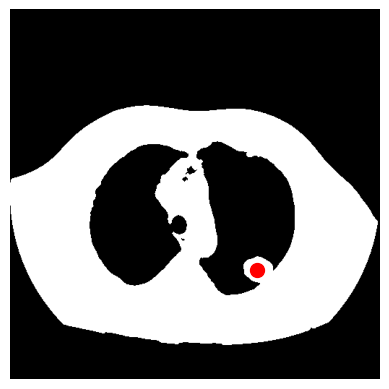

In [40]:
from skimage import morphology
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def refined_segment_nodule_with_irc_dot(slice_image, irc, threshold=-400):
    # Thresholding
    binary_mask = (slice_image > threshold).astype(np.uint8)
    opened_mask = morphology.opening(binary_mask, morphology.disk(2))
    labeled_mask = label(opened_mask)
    regions = regionprops(labeled_mask)
    if not regions:
        return np.zeros_like(slice_image)
    largest_region = max(regions, key=lambda x: x.area)
    output_mask = np.zeros_like(slice_image)
    output_mask[labeled_mask == largest_region.label] = 255
    plt.imshow(output_mask, cmap='gray')
    plt.scatter(irc[2], irc[1], c='r', s=100)  
    plt.axis('off')
    plt.show()
nodule_slice = ct_scan[irc[0]]
refined_segment_nodule_with_irc_dot(nodule_slice, irc)
